In [1]:
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
advertising = pd.read_csv('Advertising.csv')
advertising.head()


,TV,Radio,Sales
0,230.1,37.8,22.1
1,44.5,39.3,10.4
2,17.2,45.9,9.3
3,151.5,41.3,18.5
4,180.8,10.8,12.9


In [3]:
print(advertising.shape)

(200, 3)


In [4]:
XYZ = advertising.values.reshape(-1,3).astype(np.int32)

In [5]:
batch_size = 20
iterations = int(XYZ.shape[0]/batch_size)
value = np.reshape(np.array([1,1,1]),(-1, 1)).astype(np.float32)
epoch = 0  
lr = 0.00001
decay = 0.0001
memory_size = (batch_size+1)*(XYZ.shape[1]+1)

In [6]:
from pynq import Xlnk
import numpy as np
from pynq import Overlay
import pynq.lib.dma

# Load the overlay
overlay = Overlay('/home/xilinx/jupyter_notebooks/Lab9/custom_AXIS_linear_regression.bit')
# Load the FIR DMA
dma = overlay.axi_dma_0

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(memory_size,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(memory_size,), dtype=np.int32)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  if sys.path[0] == '':


In [7]:
class LinearModel(object):
    def __init__(self, value, lr):
        self.theta = value
        self.lr = lr
        
    def model(self,x): 
        ones = np.ones(x.shape[0])
        x = np.insert(x, 0, ones, axis=1)  
        return np.matmul(x,self.theta)     
    
    def gradient_calc_hw(self,x,y):
        ones = np.ones(x.shape[0])
        x = np.insert(x, 0, ones, axis=1)
        x = np.insert(x, x.shape[1], y.flatten()*100, axis=1)
        theta = (self.theta *100).astype(np.int32)
        theta = np.append(theta, np.array([0]))
        x = np.insert(x, x.shape[0], theta, axis=0)
        x_reshape = np.reshape(x,memory_size)
        
        np.copyto(in_buffer,x_reshape)
        dma.sendchannel.transfer(in_buffer)
        dma.recvchannel.transfer(out_buffer)
        dma.sendchannel.wait()
        dma.recvchannel.wait()
        
        gradient = out_buffer[-3:]
       
        return gradient
    
    def gradient_descent(self, gradient, learning_rate = 0.1):
        self.theta -= gradient*learning_rate     
        
    def fit_hw(self, X, Y):
        gradient = self.gradient_calc_hw(X, Y)
        gradient_f = gradient*2/len(Y)/100 
        gradient_f = gradient_f.reshape(-1,1)
        self.gradient_descent(gradient_f,self.lr) 

In [8]:
while True:
    cost = 0
    if epoch > 50:
        break
    for i in range(iterations):
        X= XYZ[i:i+batch_size,0:2] #advertising[['TV', 'Radio']]
        Y = XYZ[i:i+batch_size,2:] #advertising['Sales']
        lm = LinearModel(value,lr)
        lm.fit_hw(X,Y)
        cost += np.average((Y-lm.model(X))**2)
        value = lm.theta
    print ('---------------------------- epoch: %d  loss: %0.7f'% (epoch, cost/iterations))
    lr = lr * 1/(1 + decay * epoch)
    epoch +=1

---------------------------- epoch: 0  loss: 1287.4688263
---------------------------- epoch: 1  loss: 116.7878143
---------------------------- epoch: 2  loss: 102.4787137
---------------------------- epoch: 3  loss: 89.9877812
---------------------------- epoch: 4  loss: 78.9432668
---------------------------- epoch: 5  loss: 68.8879545
---------------------------- epoch: 6  loss: 60.4112804
---------------------------- epoch: 7  loss: 53.3919299
---------------------------- epoch: 8  loss: 47.3314829
---------------------------- epoch: 9  loss: 41.6590037
---------------------------- epoch: 10  loss: 37.0934589
---------------------------- epoch: 11  loss: 32.7548320
---------------------------- epoch: 12  loss: 29.0602917
---------------------------- epoch: 13  loss: 25.6260684
---------------------------- epoch: 14  loss: 23.3050933
---------------------------- epoch: 15  loss: 20.5631272
---------------------------- epoch: 16  loss: 18.1257974
---------------------------- epoch: 1

In [9]:
lm.theta.flatten()

array([0.9852142 , 0.05193997, 0.2397466 ], dtype=float32)

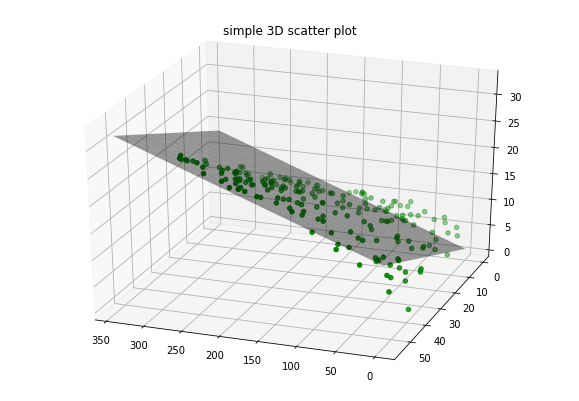

In [10]:
x = XYZ[:,0:1]
y = XYZ[:,1:2]
z = XYZ[:,2:]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
x_surf = np.arange(0, 350, 20)   # generate a mesh
y_surf = np.arange(0, 60, 4)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

ax.plot_surface(x_surf, y_surf,
                lm.theta.flatten()[1]*x_surf+ lm.theta.flatten()[2]*y_surf+lm.theta.flatten()[0],
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

plt.title("simple 3D scatter plot")
ax.view_init(elev=28, azim=110)
plt.show()